<a href="https://colab.research.google.com/github/sayevvv/PBL_MoneyClassification/blob/main/PBL_SVMV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SVM V2
pada Fitur Gabungan (Warna + Tekstur + Bentuk)

Langkah-langkah:
1. Load fitur V2 (X_v2) dan label (y_v2).
2. (BARU) Kumpulkan semua path gambar asli untuk visualisasi.
3. Encode label dan bagi data (X, y, dan path) menjadi train/test set.
4. Lakukan Preprocessing Model (StandardScaler) pada data X.
5. Lakukan Hyperparameter Tuning (GridSearchCV).
6. Evaluasi model (Classification Report & Confusion Matrix).
7. (BARU) Visualisasikan hasil prediksi pada gambar tes.
8. Simpan model V2 yang sudah terlatih.

In [1]:
# -----------------------------------------------------
# LANGKAH 1: IMPORT LIBRARY DAN MOUNT DRIVE
# -----------------------------------------------------
import os
import cv2  # Dibutuhkan untuk membaca gambar di visualisasi
import joblib
import numpy as np
from tqdm import tqdm
from google.colab import drive

# Import dari Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -----------------------------------------------------
# LANGKAH 2: KONFIGURASI DAN LOAD DATA FITUR V2
# -----------------------------------------------------

# Path tempat Anda menyimpan file .joblib V2
BASE_DIR = '/content/drive/MyDrive/tugas_akhir_semester5/raw_data'
LABELS = ['1000', '2000', '5000', '10000', '20000', '50000', '100000']
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

# --- GUNAKAN NAMA FILE V2 ---
PATH_X = os.path.join(BASE_DIR, 'features_X_v2.joblib')
PATH_Y = os.path.join(BASE_DIR, 'labels_y_v2.joblib')

print("Memuat data fitur V2 yang telah diproses...")

# Cek apakah file ada
if not os.path.exists(PATH_X) or not os.path.exists(PATH_Y):
    print(f"Error: File 'features_X_v2.joblib' atau 'labels_y_v2.joblib' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan skrip 'preprocess_dataset_v2.py' terlebih dahulu.")
else:
    X = joblib.load(PATH_X)
    y = joblib.load(PATH_Y)

    print(f"Data V2 berhasil dimuat.")
    print(f"Bentuk (shape) X_v2: {X.shape}")
    print(f"Bentuk (shape) y_v2: {y.shape}")

Memuat data fitur V2 yang telah diproses...
Data V2 berhasil dimuat.
Bentuk (shape) X_v2: (1651, 469)
Bentuk (shape) y_v2: (1651,)


In [3]:
    # -----------------------------------------------------
    # LANGKAH 3: (BARU) KUMPULKAN PATH GAMBAR
    # -----------------------------------------------------
    # Kita perlu path gambar asli untuk visualisasi di Langkah 8
    # Kita HARUS mengumpulkannya dalam urutan yang SAMA PERSIS
    # dengan skrip preprocessing.

    print("\nMengumpulkan path gambar asli untuk visualisasi...")
    filepaths = []

    # Loop ini harus sama persis dengan 'preprocess_dataset_v2.py'
    for label in LABELS:
        label_path = os.path.join(BASE_DIR, label)

        if not os.path.isdir(label_path):
            continue

        image_files = os.listdir(label_path)

        for image_file in tqdm(image_files, desc=f"Mengindeks {label}"):
            if image_file.lower().endswith(VALID_EXTENSIONS):
                full_path = os.path.join(label_path, image_file)
                filepaths.append(full_path)

    print("Path gambar berhasil dikumpulkan.")

    # Pengecekan Kritis: Pastikan jumlah fitur sama dengan jumlah path
    if len(filepaths) != X.shape[0]:
        print(f"PERINGATAN KRITIS: Jumlah fitur ({X.shape[0]}) tidak cocok "
              f"dengan jumlah path gambar ({len(filepaths)}).")
        print("Visualisasi mungkin tidak akan akurat.")
    else:
        print("Jumlah fitur dan path gambar cocok. Melanjutkan...")



Mengumpulkan path gambar asli untuk visualisasi...


Mengindeks 100000: 100%|██████████| 240/240 [00:00<00:00, 243030.65it/s]

Path gambar berhasil dikumpulkan.
Jumlah fitur dan path gambar cocok. Melanjutkan...


In [4]:
    # -----------------------------------------------------
    # LANGKAH 4: ENCODE LABEL DAN BAGI DATA
    # -----------------------------------------------------

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    class_names = le.classes_
    print(f"\nLabel berhasil di-encode. Kelas: {class_names}")

    # Simpan LabelEncoder ini! Penting untuk Flask
    le_path = os.path.join(BASE_DIR, 'label_encoder_v2.joblib')
    joblib.dump(le, le_path)
    print(f"LabelEncoder V2 disimpan di: {le_path}")

    # (BARU) Bagi data X, y, dan filepaths secara bersamaan
    X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
        X, y_encoded, filepaths,
        test_size=0.2,    # 20% untuk data tes
        random_state=42,  # Pastikan random_state SAMA
        stratify=y_encoded
    )

    print(f"\nData dibagi:")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"Jumlah path tes: {len(paths_test)}")


Label berhasil di-encode. Kelas: ['1000' '10000' '100000' '2000' '20000' '5000' '50000']
LabelEncoder V2 disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/label_encoder_v2.joblib

Data dibagi:
X_train shape: (1320, 469)
X_test shape: (331, 469)
Jumlah path tes: 331


In [5]:
    # -----------------------------------------------------
    # LANGKAH 5: PREPROCESSING MODEL (SCALING)
    # -----------------------------------------------------

    print("\nMelakukan StandardScaler pada fitur V2...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("Scaling V2 selesai.")

    # Simpan scaler V2
    scaler_path = os.path.join(BASE_DIR, 'svm_scaler_v2.joblib')
    joblib.dump(scaler, scaler_path)
    print(f"Scaler V2 disimpan di: {scaler_path}")

    # -----------------------------------------------------
    # LANGKAH 6: HYPERPARAMETER TUNING (GRIDSEARCHCV)
    # -----------------------------------------------------

    print("\nMemulai Hyperparameter Tuning dengan GridSearchCV untuk V2...")
    print("Ini mungkin memakan waktu beberapa menit (atau lebih lama dari V1)...")

    param_grid = {
        'C': [1, 10, 100],        # Dengan fitur yang lebih baik, kita bisa coba C yang lebih tinggi
        'gamma': [0.1, 0.01, 0.001], # Mungkin perlu gamma yang lebih kecil
        'kernel': ['rbf']
    }

    grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=3, n_jobs=-1)
    grid.fit(X_train_scaled, y_train)




Melakukan StandardScaler pada fitur V2...
Scaling V2 selesai.
Scaler V2 disimpan di: /content/drive/MyDrive/tugas_akhir_semester5/raw_data/svm_scaler_v2.joblib

Memulai Hyperparameter Tuning dengan GridSearchCV untuk V2...
Ini mungkin memakan waktu beberapa menit (atau lebih lama dari V1)...
Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['rbf']},
             verbose=2)


Tuning V2 selesai!
Parameter terbaik yang ditemukan: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

--- Laporan Klasifikasi SVM (V2) ---
              precision    recall  f1-score   support

        1000       0.96      1.00      0.98        48
       10000       1.00      0.96      0.98        48
      100000       1.00      0.98      0.99        48
        2000       0.96      0.98      0.97        48
       20000       1.00      1.00      1.00        48
        5000       0.96      0.98      0.97        45
       50000       1.00      0.98      0.99        46

    accuracy                           0.98       331
   macro avg       0.98      0.98      0.98       331
weighted avg       0.98      0.98      0.98       331

Akurasi Keseluruhan (V2): 98.19%

--- Confusion Matrix (V2) ---


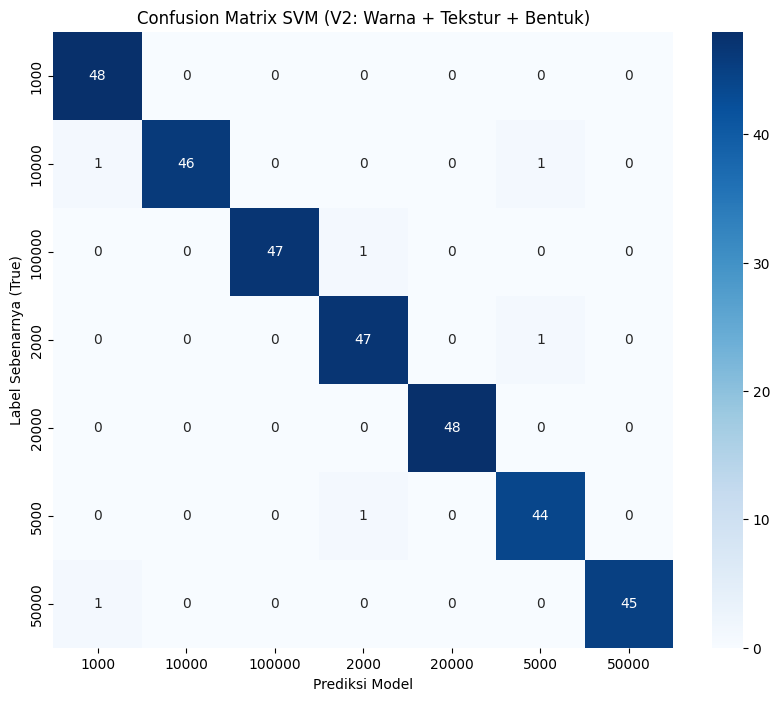

In [6]:
    # -----------------------------------------------------
    # LANGKAH 7: EVALUASI MODEL V2
    # -----------------------------------------------------

    print("\nTuning V2 selesai!")
    print(f"Parameter terbaik yang ditemukan: {grid.best_params_}")

    best_svm = grid.best_estimator_
    y_pred = best_svm.predict(X_test_scaled)

    print("\n--- Laporan Klasifikasi SVM (V2) ---")
    print(classification_report(y_test, y_pred, target_names=class_names))

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi Keseluruhan (V2): {accuracy * 100:.2f}%")

    print("\n--- Confusion Matrix (V2) ---")
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Sebenarnya (True)')
    plt.title('Confusion Matrix SVM (V2: Warna + Tekstur + Bentuk)')
    plt.show()


Memulai visualisasi hasil prediksi pada data tes...
Total tebakan benar: 325
Total tebakan salah: 6


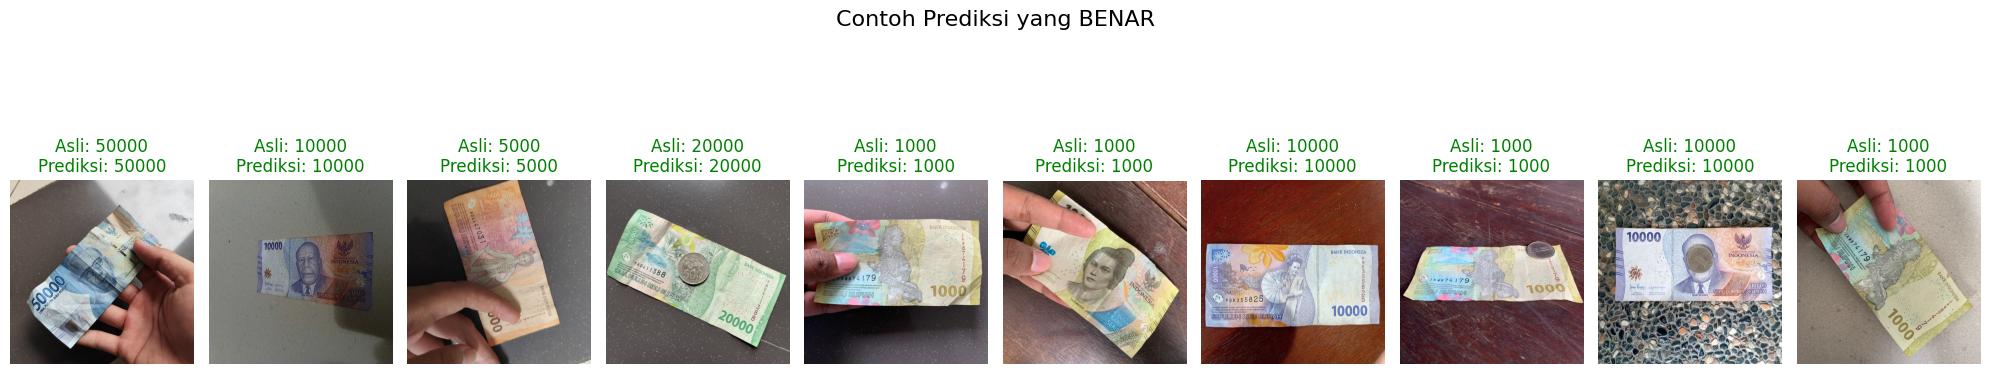

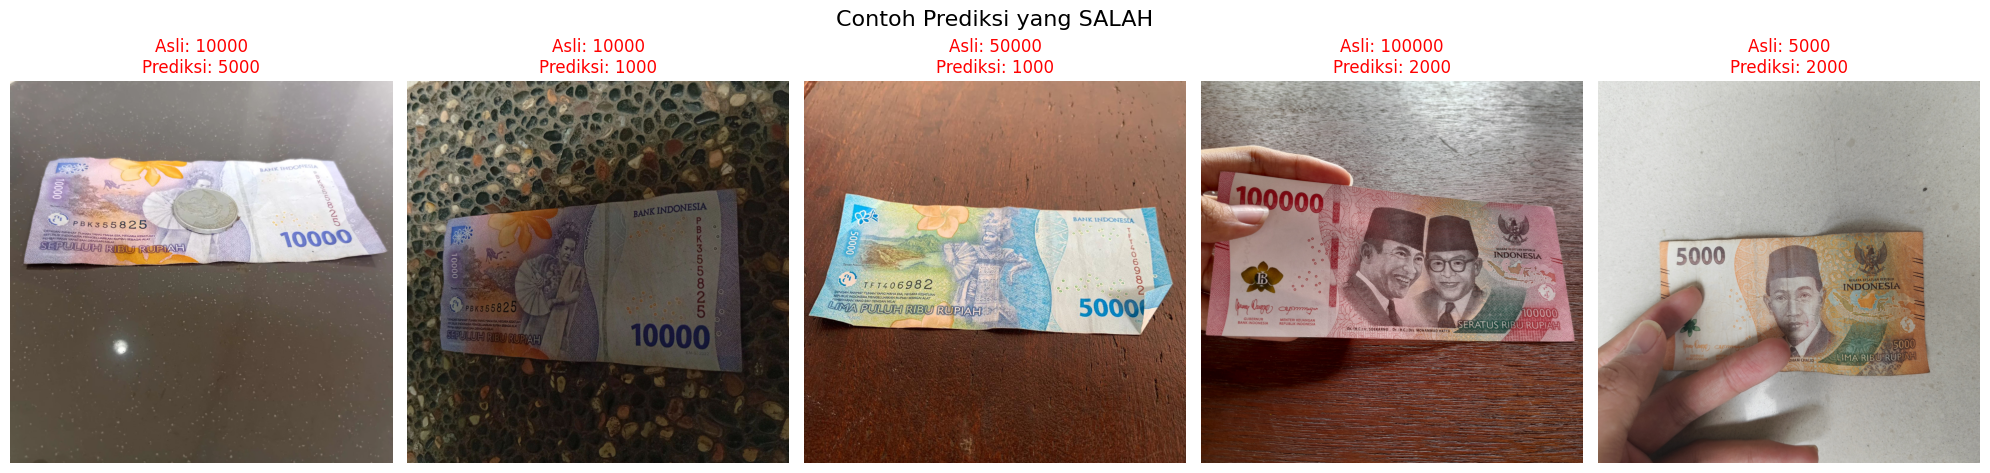

In [8]:
    # -----------------------------------------------------
    # LANGKAH 8: (BARU) VISUALISASI HASIL TES
    # -----------------------------------------------------

    print("\nMemulai visualisasi hasil prediksi pada data tes...")

    # Temukan indeks dari prediksi yang benar dan salah
    correct_indices = np.where(y_pred == y_test)[0]
    incorrect_indices = np.where(y_pred != y_test)[0]

    print(f"Total tebakan benar: {len(correct_indices)}")
    print(f"Total tebakan salah: {len(incorrect_indices)}")

    # Fungsi untuk menampilkan gambar
    def show_prediction_images(indices, title, n_images=5):
        if len(indices) == 0:
            print(f"Tidak ada gambar untuk ditampilkan (tidak ada {title.lower()})")
            return

        # Ambil N gambar secara acak dari indeks
        sample_indices = np.random.choice(indices, min(n_images, len(indices)), replace=False)

        plt.figure(figsize=(20, 5))
        plt.suptitle(f"Contoh Prediksi yang {title}", fontsize=16)

        for i, idx in enumerate(sample_indices):
            # Baca gambar dari path
            img_path = paths_test[idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Konversi BGR ke RGB untuk plt

            # Dapatkan label
            true_label = class_names[y_test[idx]]
            pred_label = class_names[y_pred[idx]]

            # Tentukan warna judul
            color = "green" if title == "BENAR" else "red"

            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(f"Asli: {true_label}\nPrediksi: {pred_label}", color=color)
            plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Tampilkan 5 contoh yang BENAR
    show_prediction_images(correct_indices, "BENAR", n_images=10)

    # Tampilkan 5 contoh yang SALAH (jika ada)
    show_prediction_images(incorrect_indices, "SALAH", n_images=5)
